In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
keras = tf.keras


2023-03-15 15:43:33.234037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
test = tf.data.Dataset.from_tensor_slices([1, 2, 3])

2023-03-15 15:43:37.902231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:


import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism



In [4]:
Q_MEAN = 0.5
EPOCH = 2
POPULATION_SIZE = 10000
TRAIN_DIM = 100
STEP = 1

In [5]:

import numpy as np

def initialize_with_str_seed(init_str):
    """
    Initializes random number generator with seed corresponding to given input string init_str.
    :param init_str: Initialization string according to which seed will be computed. Seed is the sum of the ASCII
                     values of each character in init_str.
    """
    rnd_val = 0
    if init_str:
        for c in init_str:
            rnd_val += ord(c)
    np.random.seed(rnd_val)

def gen_data(n, d, seed = None):
    if seed:
        initialize_with_str_seed(seed)
    p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
    data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
    data_y = np.random.choice([0, 1], n, p=[1 -p, p])
    return data, data_y

def gen_valid(n, d, seed = None):
    if seed:
        initialize_with_str_seed(seed)
    
    n = int(n/10)
    
    p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
    data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
    data_y = np.random.choice([0, 1], n, p=[1 -p, p])
    return data, data_y



In [6]:
import math

x_train, y_train = gen_data(POPULATION_SIZE, TRAIN_DIM)
x_valid, y_valid = gen_data(int(POPULATION_SIZE/500), TRAIN_DIM)


In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [8]:

def compile_and_fit_model(model, train_set, epoch_num = EPOCH, eager = False):

    
    lr_schedule = keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"],
                run_eagerly = eager)

    history = model.fit(train_set, epochs = epoch_num, callbacks=[lr_schedule])
    return history

def eval_model(train_size, epoch_num = EPOCH, mechanism = Mechanism(Mechanism.MechanismType.NONE)):
    ''' Compile and fit the empirical model as baseline'''
    model = MechanizedSequential([
        keras.layers.Conv1D(filters = 32,
                            kernel_size = 5,
                            strides = 1, 
                            padding = "causal",
                            activation = "relu",
                            input_shape = [None, 1]),
        # keras.layers.LSTM(32, return_sequences = True),
        # keras.layers.LSTM(32, return_sequences=True),
        keras.layers.Dense(1),
        keras.layers.Lambda(lambda x: x * 200)
    ])    
    batch_size = math.floor(train_size/STEP)
    train_set = tf.data.Dataset.from_tensor_slices((x_train[:train_size], y_train[:train_size])).batch(batch_size)


    if not (mechanism.mechanism_type == Mechanism.MechanismType.NONE):
        model.choose_mech(mechanism)
        history = compile_and_fit_model(model, train_set, epoch_num, True)
    else:
        history = compile_and_fit_model(model, train_set, epoch_num, False)


    ''' Validate the result'''
    # x_valid, y_valid = gen_valid(POPULATION_SIZE, TRAIN_DIM)
    # model.choose_mech(None)
    predict = model.predict(x_valid)
    
    error = generalization_error(y_valid, predict)
    return history, predict, error


def generalization_error(true_val, predict_val):
    error = keras.metrics.RootMeanSquaredError()
    error.update_state(true_val, predict_val)
    return error.result().numpy()



def eval_const_rounds(stepped_train_size, epoch_num = EPOCH, mechanism = Mechanism(Mechanism.MechanismType.NONE)):
    history_list, predict_list, generalization_error_list = [], [], []
    for n in stepped_train_size:
        history, predict, error = eval_model(train_size = n, epoch_num = epoch_num, mechanism = mechanism)
        history_list.append(history)
        predict_list.append(predict)
        generalization_error_list.append(error) 

    return history_list, predict_list, generalization_error_list




# Evaluate the Model

In [9]:


'''
Plot the Comparison of the Three Model
'''
def plot_error(rounds, generalization_error, mechanism):
    plt.plot(rounds, generalization_error, label = mechanism)
    plt.xlabel("Queries")
    plt.ylabel("RMSE (Generalization Error) for adaptive queries")
    plt.legend()
    plt.grid()


In [41]:
max_query_num = 1000

stepped_query_num = range(math.floor(max_query_num/2), max_query_num, 50)

In [42]:
baseline_generalization_error_list = eval_const_rounds(stepped_query_num)[2]
print(baseline_generalization_error_list)

Epoch 1/2
1/1 [==============================] - 1s 964ms/step - loss: 21.5941 - mae: 22.0920 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 71ms/step


Epoch 1/2
1/1 [==============================] - 1s 815ms/step - loss: 29.6716 - mae: 30.1714 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 72ms/step


Epoch 1/2
1/1 [==============================] - 1s 876ms/step - loss: 19.2820 - mae: 19.7797 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 69ms/step


Epoch 1/2
1/1 [==============================] - 1s 914ms/step - loss: 33.6565 - mae: 34.1564 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 69ms/step


Epoch 1/2
1/1 [==============================] - 1s 1s/step - loss: 45.0355 - mae: 45.5331 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 69ms/step


Epoch 1/2
1/1 [==============================] - 1s 1s/step - loss: 16.0470 - mae: 16.5394 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 70ms/step


Epoch 1/2
1/1 [==============================] - 1s 1s/step - loss: 41.7832 - mae: 42.2832 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 70ms/step


Epoch 1/2
1/1 [==============================] - 1s 1s/step - loss: 50.4973 - mae: 50.9913 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 73ms/step


Epoch 1/2
1/1 [==============================] - 1s 1s/step - loss: 17.8158 - mae: 18.2978 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 71ms/step


Epoch 1/2
1/1 [==============================] - 2s 2s/step - loss: 24.6659 - mae: 25.1596 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 68ms/step
[27.000954, 35.70302, 24.04751, 41.548985, 56.0531, 21.092932, 47.216404, 61.22076, 23.826529, 32.282017]


In [ ]:
''' eval the empirical model as baseline'''
baseline_generalization_error_list = [eval_const_rounds(stepped_query_num)[2] for _ in range(100)]
print(np.mean(baseline_generalization_error_list, axis = 0))
"""
[13.719473]
[10.51995]
"""

In [43]:
gaussian_generalization_error_list = eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.GAUSSIAN, sigma = 0.03))[2]
print((gaussian_generalization_error_list))

Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 904ms/step - loss: 33.7918 - mae: 34.2876 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 24ms/step


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 904ms/step - loss: 48.6910 - mae: 49.1865 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 21ms/step


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 981ms/step - loss: 38.8081 - mae: 39.3081 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 22ms/step


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 1s/step - loss: 27.2405 - mae: 27.7405 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 22ms/step


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 1s/step - loss: 28.7551 - mae: 29.2443 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 25ms/step


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 2s 2s/step - loss: 25.9995 - mae: 26.4965 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 20ms/step


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 2s 2s/step - loss: 40.5101 - mae: 41.0095 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 22ms/step


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 2s 2s/step - loss: 32.3140 - mae: 32.8140 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 22ms/step


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 2s 2s/step - loss: 36.6809 - mae: 37.1807 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 22ms/step


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 2s 2s/step - loss: 38.7197 - mae: 39.2137 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 20ms/step
[44.178738, 64.66862, 51.54056, 34.705208, 37.65286, 31.933472, 46.915653, 39.42634, 48.110718, 50.332005]


In [ ]:

gaussian_generalization_error_list = [eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.GAUSSIAN, sigma = 0.03))[2] for _ in range(100)]
print(np.mean(gaussian_generalization_error_list, axis = 0))

In [44]:

''' Compile and fit the threshold out model'''
_, _, threshold_generalization_error_list = eval_const_rounds(stepped_train_size = stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.THRESHOLD, sigma = 0.1, hold_frac = 0.7, threshold = 0.5))
print(threshold_generalization_error_list)
"""
[3.270109] 
"""


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 1s 858ms/step - loss: 25.4643 - mae: 25.9430 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 22ms/step


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 1s 893ms/step - loss: 37.7158 - mae: 38.2172 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 25ms/step


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 1s 1s/step - loss: 24.7449 - mae: 25.2361 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 20ms/step


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 1s 1s/step - loss: 29.7148 - mae: 30.1751 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 21ms/step


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 1s 1s/step - loss: 59.4407 - mae: 59.9490 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 21ms/step


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 1s 1s/step - loss: 36.1578 - mae: 36.6643 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 20ms/step


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 2s 2s/step - loss: 35.2073 - mae: 35.6996 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 20ms/step


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 2s 2s/step - loss: 31.4419 - mae: 31.9661 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 20ms/step


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 2s 2s/step - loss: 37.1050 - mae: 37.5999 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 19ms/step


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 2s 2s/step - loss: 23.4805 - mae: 23.9545 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 19ms/step
[33.9799, 47.68499, 33.545452, 34.82338, 70.45554, 45.408722, 39.08446, 40.44787, 46.703396, 29.859106]


'\n[3.270109] \n'

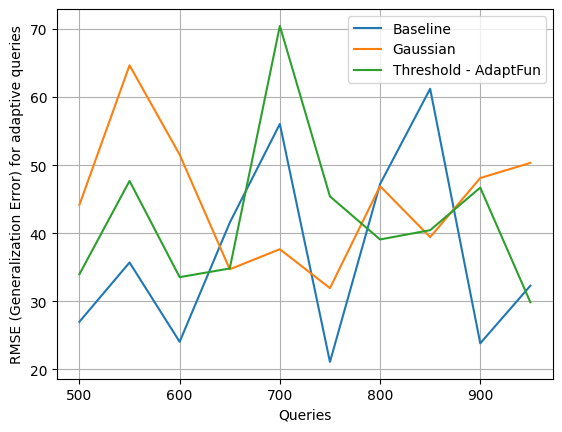

In [45]:

""" plot the generalization error """
plt.figure()
plot_error(stepped_query_num, baseline_generalization_error_list, "Baseline")
plot_error(stepped_query_num, gaussian_generalization_error_list, "Gaussian")
plot_error(stepped_query_num, threshold_generalization_error_list, "Threshold - AdaptFun")
plt.show()

# Evaluate the O(n) adaptivity

In [26]:

def eval_multiple_rounds(train_size, stepped_epoch_num, mechanism = Mechanism(Mechanism.MechanismType.NONE)):
    history_list, predict_list, generalization_error_list = [], [], []
    for r in stepped_epoch_num:
        history, predict, error = eval_model(train_size = train_size, epoch_num = r, mechanism = mechanism)
        history_list.append(history)
        predict_list.append(predict)
        generalization_error_list.append(error) 

    return history_list, predict_list, generalization_error_list

In [34]:
max_query_num = 100
max_rounds = 100
stepped_rounds = range(math.floor(max_rounds/2), max_rounds, 20)

In [35]:
''' eval the empirical model as baseline'''
baselin_history_list, baseline_predict_list, baseline_generalization_error_list = eval_multiple_rounds(max_query_num, stepped_rounds)
print(baseline_generalization_error_list)

Epoch 1/50
1/1 [==============================] - 0s 483ms/step - loss: 26.4344 - mae: 26.9344 - lr: 1.0000e-08
Epoch 2/50
1/1 [==============================] - 0s 17ms/step - loss: 26.4338 - mae: 26.9338 - lr: 1.1220e-08
Epoch 3/50
1/1 [==============================] - 0s 18ms/step - loss: 26.4326 - mae: 26.9326 - lr: 1.2589e-08
Epoch 4/50
1/1 [==============================] - 0s 21ms/step - loss: 26.4307 - mae: 26.9307 - lr: 1.4125e-08
Epoch 5/50
1/1 [==============================] - 0s 60ms/step - loss: 26.4281 - mae: 26.9281 - lr: 1.5849e-08
Epoch 6/50
1/1 [==============================] - 0s 21ms/step - loss: 26.4248 - mae: 26.9249 - lr: 1.7783e-08
Epoch 7/50
1/1 [==============================] - 0s 18ms/step - loss: 26.4208 - mae: 26.9208 - lr: 1.9953e-08
Epoch 8/50
1/1 [==============================] - 0s 20ms/step - loss: 26.4159 - mae: 26.9160 - lr: 2.2387e-08
Epoch 9/50
1/1 [==============================] - 0s 18ms/step - loss: 26.4102 - mae: 26.9102 - lr: 2.5119e-08


Epoch 1/70
1/1 [==============================] - 0s 412ms/step - loss: 36.4163 - mae: 36.9136 - lr: 1.0000e-08
Epoch 2/70
1/1 [==============================] - 0s 20ms/step - loss: 36.4161 - mae: 36.9134 - lr: 1.1220e-08
Epoch 3/70
1/1 [==============================] - 0s 20ms/step - loss: 36.4158 - mae: 36.9131 - lr: 1.2589e-08
Epoch 4/70
1/1 [==============================] - 0s 18ms/step - loss: 36.4153 - mae: 36.9126 - lr: 1.4125e-08
Epoch 5/70
1/1 [==============================] - 0s 17ms/step - loss: 36.4146 - mae: 36.9119 - lr: 1.5849e-08
Epoch 6/70
1/1 [==============================] - 0s 19ms/step - loss: 36.4137 - mae: 36.9110 - lr: 1.7783e-08
Epoch 7/70
1/1 [==============================] - 0s 61ms/step - loss: 36.4126 - mae: 36.9099 - lr: 1.9953e-08
Epoch 8/70
1/1 [==============================] - 0s 19ms/step - loss: 36.4113 - mae: 36.9086 - lr: 2.2387e-08
Epoch 9/70
1/1 [==============================] - 0s 20ms/step - loss: 36.4098 - mae: 36.9071 - lr: 2.5119e-08


Epoch 1/90
1/1 [==============================] - 0s 410ms/step - loss: 31.2447 - mae: 31.7405 - lr: 1.0000e-08
Epoch 2/90
1/1 [==============================] - 0s 17ms/step - loss: 31.2444 - mae: 31.7402 - lr: 1.1220e-08
Epoch 3/90
1/1 [==============================] - 0s 18ms/step - loss: 31.2438 - mae: 31.7397 - lr: 1.2589e-08
Epoch 4/90
1/1 [==============================] - 0s 18ms/step - loss: 31.2430 - mae: 31.7388 - lr: 1.4125e-08
Epoch 5/90
1/1 [==============================] - 0s 19ms/step - loss: 31.2418 - mae: 31.7377 - lr: 1.5849e-08
Epoch 6/90
1/1 [==============================] - 0s 18ms/step - loss: 31.2404 - mae: 31.7362 - lr: 1.7783e-08
Epoch 7/90
1/1 [==============================] - 0s 18ms/step - loss: 31.2385 - mae: 31.7343 - lr: 1.9953e-08
Epoch 8/90
1/1 [==============================] - 0s 18ms/step - loss: 31.2363 - mae: 31.7321 - lr: 2.2387e-08
Epoch 9/90
1/1 [==============================] - 0s 41ms/step - loss: 31.2337 - mae: 31.7295 - lr: 2.5119e-08


In [36]:
''' Compile and fit the gaussian model'''
_, _, gaussian_generalization_error_list = eval_multiple_rounds(max_query_num, stepped_rounds, mechanism = Mechanism(Mechanism.MechanismType.GAUSSIAN, sigma = 0.03))

Epoch 1/50
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 52ms/step - loss: 37.8744 - mae: 38.3742 - lr: 1.0000e-08
Epoch 2/50
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 50ms/step - loss: 37.8748 - mae: 38.3745 - lr: 1.1220e-08
Epoch 3/50
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 48ms/step - loss: 37.8734 - mae: 38.3732 - lr: 1.2589e-08
Epoch 4/50
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 49ms/step - loss: 37.8725 - mae: 38.3723 - lr: 1.4125e-08
Epoch 5/50
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 49ms/step - loss: 37.8719 - mae: 38.3717 - lr: 1.5849e-08
Epoch 6/50
In Gaussian Mechanism
Create Gaussian noise when 

Epoch 1/70
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 57ms/step - loss: 25.3198 - mae: 25.8155 - lr: 1.0000e-08
Epoch 2/70
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 53ms/step - loss: 25.3190 - mae: 25.8147 - lr: 1.1220e-08
Epoch 3/70
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 46ms/step - loss: 25.3195 - mae: 25.8152 - lr: 1.2589e-08
Epoch 4/70
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 49ms/step - loss: 25.3188 - mae: 25.8145 - lr: 1.4125e-08
Epoch 5/70
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 48ms/step - loss: 25.3183 - mae: 25.8141 - lr: 1.5849e-08
Epoch 6/70
In Gaussian Mechanism
Create Gaussian noise when 

Epoch 1/90
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 59ms/step - loss: 23.6837 - mae: 24.1684 - lr: 1.0000e-08
Epoch 2/90
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 54ms/step - loss: 23.6840 - mae: 24.1687 - lr: 1.1220e-08
Epoch 3/90
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 55ms/step - loss: 23.6830 - mae: 24.1677 - lr: 1.2589e-08
Epoch 4/90
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 54ms/step - loss: 23.6830 - mae: 24.1678 - lr: 1.4125e-08
Epoch 5/90
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 54ms/step - loss: 23.6816 - mae: 24.1664 - lr: 1.5849e-08
Epoch 6/90
In Gaussian Mechanism
Create Gaussian noise when 

In [37]:
print(gaussian_generalization_error_list)

[46.836067, 15.44279, 6.306488]


In [38]:

''' Compile and fit the threshold out model'''
threshold_history_list, threshold_predict_list, threshold_generalization_error_list = eval_multiple_rounds(max_query_num, stepped_rounds, mechanism = Mechanism(Mechanism.MechanismType.THRESHOLD, sigma = 0.1, hold_frac = 0.4, threshold = 0.5))
print(threshold_generalization_error_list)

Epoch 1/50
In Threshold out Mechanism
1/1 [==============================] - 0s 119ms/step - loss: 23.3108 - mae: 23.7736 - lr: 1.0000e-08
Epoch 2/50
In Threshold out Mechanism
1/1 [==============================] - 0s 127ms/step - loss: 23.3107 - mae: 23.7735 - lr: 1.1220e-08
Epoch 3/50
In Threshold out Mechanism
1/1 [==============================] - 0s 105ms/step - loss: 23.3103 - mae: 23.7731 - lr: 1.2589e-08
Epoch 4/50
In Threshold out Mechanism
1/1 [==============================] - 0s 130ms/step - loss: 23.3098 - mae: 23.7726 - lr: 1.4125e-08
Epoch 5/50
In Threshold out Mechanism
1/1 [==============================] - 0s 108ms/step - loss: 23.3249 - mae: 23.8640 - lr: 1.5849e-08
Epoch 6/50
In Threshold out Mechanism
1/1 [==============================] - 0s 105ms/step - loss: 23.3083 - mae: 23.7711 - lr: 1.7783e-08
Epoch 7/50
In Threshold out Mechanism
1/1 [==============================] - 0s 99ms/step - loss: 23.3072 - mae: 23.7701 - lr: 1.9953e-08
Epoch 8/50
In Threshold out 

Epoch 1/70
In Threshold out Mechanism
1/1 [==============================] - 0s 138ms/step - loss: 45.1939 - mae: 45.7738 - lr: 1.0000e-08
Epoch 2/70
In Threshold out Mechanism
1/1 [==============================] - 0s 112ms/step - loss: 45.1935 - mae: 45.7734 - lr: 1.1220e-08
Epoch 3/70
In Threshold out Mechanism
1/1 [==============================] - 0s 159ms/step - loss: 45.1927 - mae: 45.7726 - lr: 1.2589e-08
Epoch 4/70
In Threshold out Mechanism
1/1 [==============================] - 0s 102ms/step - loss: 45.1915 - mae: 45.7714 - lr: 1.4125e-08
Epoch 5/70
In Threshold out Mechanism
1/1 [==============================] - 0s 139ms/step - loss: 45.1899 - mae: 45.7698 - lr: 1.5849e-08
Epoch 6/70
In Threshold out Mechanism
1/1 [==============================] - 0s 94ms/step - loss: 45.1878 - mae: 45.7676 - lr: 1.7783e-08
Epoch 7/70
In Threshold out Mechanism
1/1 [==============================] - 0s 90ms/step - loss: 45.1852 - mae: 45.7651 - lr: 1.9953e-08
Epoch 8/70
In Threshold out M

Epoch 1/90
In Threshold out Mechanism
1/1 [==============================] - 0s 70ms/step - loss: 18.9983 - mae: 19.6132 - lr: 1.0000e-08
Epoch 2/90
In Threshold out Mechanism
1/1 [==============================] - 0s 138ms/step - loss: 18.9460 - mae: 19.3073 - lr: 1.1220e-08
Epoch 3/90
In Threshold out Mechanism
1/1 [==============================] - 0s 61ms/step - loss: 18.9458 - mae: 19.3070 - lr: 1.2589e-08
Epoch 4/90
In Threshold out Mechanism
1/1 [==============================] - 0s 56ms/step - loss: 18.9454 - mae: 19.3066 - lr: 1.4125e-08
Epoch 5/90
In Threshold out Mechanism
1/1 [==============================] - 0s 138ms/step - loss: 18.9448 - mae: 19.3060 - lr: 1.5849e-08
Epoch 6/90
In Threshold out Mechanism
1/1 [==============================] - 0s 52ms/step - loss: 18.9962 - mae: 19.6112 - lr: 1.7783e-08
Epoch 7/90
In Threshold out Mechanism
1/1 [==============================] - 0s 54ms/step - loss: 18.9432 - mae: 19.3045 - lr: 1.9953e-08
Epoch 8/90
In Threshold out Mech

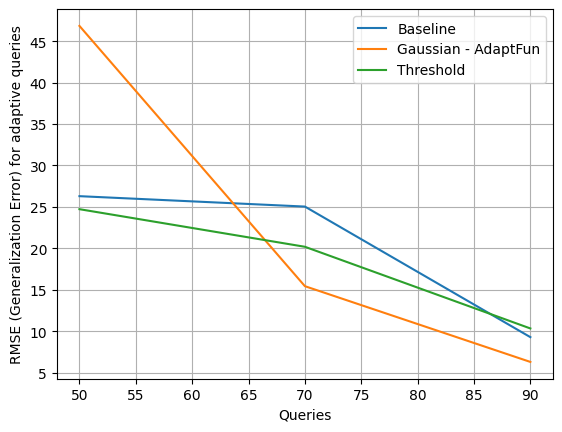

In [40]:

""" plot the generalization error """
plt.figure()
plot_error(stepped_rounds, baseline_generalization_error_list, "Baseline")
plot_error(stepped_rounds, gaussian_generalization_error_list, "Gaussian - AdaptFun")
plot_error(stepped_rounds, threshold_generalization_error_list, "Threshold")
plt.show()